#IT441-Data Science Practical 12 (Mini Project)

##Darshil Patel

##ID - 18IT080

##1. Introduction
In this project, I am investigating the dataset containing information on population, region, area size, mortality and more of 227 countries. I will be focusing on the factors that affecting a country's GDP per capita. I will also briefly discuss the total GDPs. 

##2. Load Libraries

In [2]:
import numpy as np # for linear algebra
import pandas as pd # for data processing, csv io
from matplotlib import pyplot as plt # data plots
import seaborn as sns # pretty data plots
sns.set()

from sklearn.preprocessing import LabelEncoder # for label normalization
from sklearn.model_selection import train_test_split # for splitting data into train and test subsets
from sklearn.linear_model import LinearRegression # for using Linear Regression model
from sklearn.metrics import mean_squared_error, mean_squared_log_error

import os
print(os.listdir("/Datasets"))

['Countries-GDP-Data.csv']


##3. Overview Of The Table

In [3]:
data = pd.read_csv('/Datasets/Countries-GDP-Data.csv',decimal=',')
print('Number of missing data:')
print(data.isnull().sum())
data.describe(include='all')

Number of missing data:
Country                                0
Region                                 0
Population                             0
Area (sq. mi.)                         0
Pop. Density (per sq. mi.)             0
Coastline (coast/area ratio)           0
Net migration                          3
Infant mortality (per 1000 births)     3
GDP ($ per capita)                     1
Literacy (%)                          18
Phones (per 1000)                      4
Arable (%)                             2
Crops (%)                              2
Other (%)                              2
Climate                               22
Birthrate                              3
Deathrate                              4
Agriculture                           15
Industry                              16
Service                               15
dtype: int64


,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
count,227,227,2.270000e+02,2.270000e+02,227.000000,227.000000,224.000000,224.000000,226.000000,209.000000,223.000000,225.000000,225.000000,225.000000,205.000000,224.000000,223.000000,212.000000,211.000000,212.000000
unique,227,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Syria,SUB-SAHARAN AFRICA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2.874028e+07,5.982270e+05,379.047137,21.165330,0.038125,35.506964,9689.823009,82.838278,236.061435,13.797111,4.564222,81.638311,2.139024,22.114732,9.241345,0.150844,0.282711,0.565283
std,NaN,NaN,1.178913e+08,1.790282e+06,1660.185825,72.286863,4.889269,35.389899,10049.138513,19.722173,227.991829,13.040402,8.361470,16.140835,0.699397,11.176716,4.990026,0.146798,0.138272,0.165841
min,NaN,NaN,7.026000e+03,2.000000e+00,0.000000,0.000000,-20.990000,2.290000,500.000000,17.600000,0.200000,0.000000,0.000000,33.330000,1.000000,7.290000,2.290000,0.000000,0.020000,0.062000
25%,NaN,NaN,4.376240e+05,4.647500e+03,29.150000,0.100000,-0.927500,8.150000,1900.000000,70.600000,37.800000,3.220000,0.190000,71.650000,2.000000,12.672500,5.910000,0.037750,0.193000,0.429250
50%,NaN,NaN,4.786994e+06,8.660000e+04,78.800000,0.730000,0.000000,21.000000,5550.000000,92.500000,176.200000,10.420000,1.030000,85.700000,2.000000,18.790000,7.840000,0.099000,0.272000,0.571000
75%,NaN,NaN,1.749777e+07,4.418110e+05,190.150000,10.345000,0.997500,55.705000,15700.000000,98.000000,389.650000,20.000000,4.440000,95.440000,3.000000,29.820000,10.605000,0.221000,0.341000,0.678500


##4. Data Preparation
I noticed that there are some missing data in the table. For simplicity, I will just fill the missing data using the median of the region that a country belongs, as countries that are close geologically are often similar in many ways. For example, lets check the region median of 'GDP ($ per capita)', 'Literacy (%)' and 'Agriculture'. Note that for 'climate' we use the mode instead of median as it seems that 'climate' is a categorical feature here.

In [4]:
data.groupby('Region')[['GDP ($ per capita)','Literacy (%)','Agriculture']].median()

,GDP ($ per capita),Literacy (%),Agriculture
Region,,,
ASIA (EX. NEAR EAST),3450.0,90.60,0.1610
BALTICS,11400.0,99.80,0.0400
C.W. OF IND. STATES,3450.0,99.05,0.1980
EASTERN EUROPE,9100.0,98.60,0.0815
LATIN AMER. & CARIB,6300.0,94.05,0.0700
NEAR EAST,9250.0,83.00,0.0350
NORTHERN AFRICA,6000.0,70.00,0.1320
NORTHERN AMERICA,29800.0,97.50,0.0100
OCEANIA,5000.0,95.00,0.1505


In [5]:
# Fill up missing values
for col in data.columns.values:
    if data[col].isnull().sum() == 0:
        continue
    if col == 'Climate':
        guess_values = data.groupby('Region')['Climate'].apply(lambda x: x.mode().max())
    else:
        guess_values = data.groupby('Region')[col].median()
    for region in data['Region'].unique():
        data[col].loc[(data[col].isnull())&(data['Region']==region)] = guess_values[region]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


##5. Data Exploration

###5.1 Top Countries With Highest GDP

Look at the top 20 countries with highest GDP per capita. Luxembourg is quite ahead, the next 19 countries are close to each other. Germany, the 20th has about 2.5 times GDP per capita of the world average.

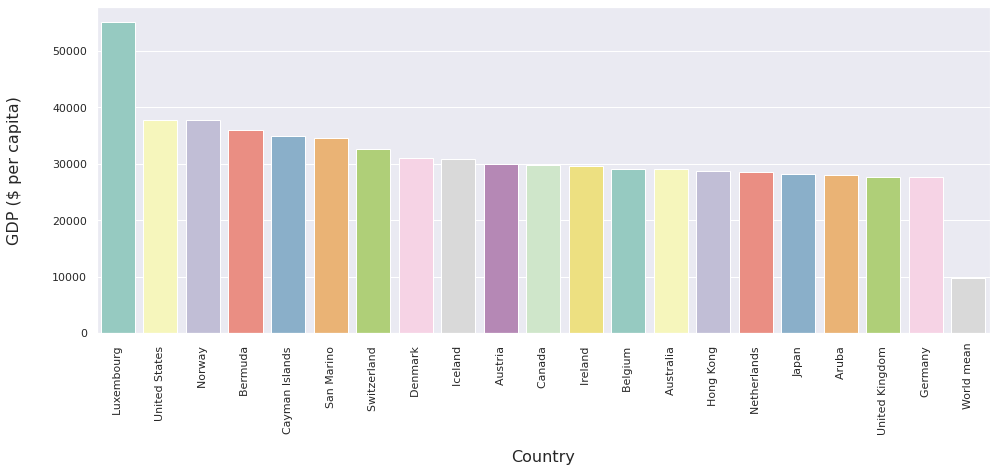

In [6]:
fig, ax = plt.subplots(figsize=(16,6))
#ax = fig.add_subplot(111)
top_gdp_countries = data.sort_values('GDP ($ per capita)',ascending=False).head(20)
mean = pd.DataFrame({'Country':['World mean'], 'GDP ($ per capita)':[data['GDP ($ per capita)'].mean()]})
gdps = pd.concat([top_gdp_countries[['Country','GDP ($ per capita)']],mean],ignore_index=True)

sns.barplot(x='Country',y='GDP ($ per capita)',data=gdps, palette='Set3')
ax.set_xlabel(ax.get_xlabel(),labelpad=15)
ax.set_ylabel(ax.get_ylabel(),labelpad=30)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
plt.xticks(rotation=90)
plt.show()

###5.2 Correlation between variables

The heatmap shows the correlation between all numerical columns.

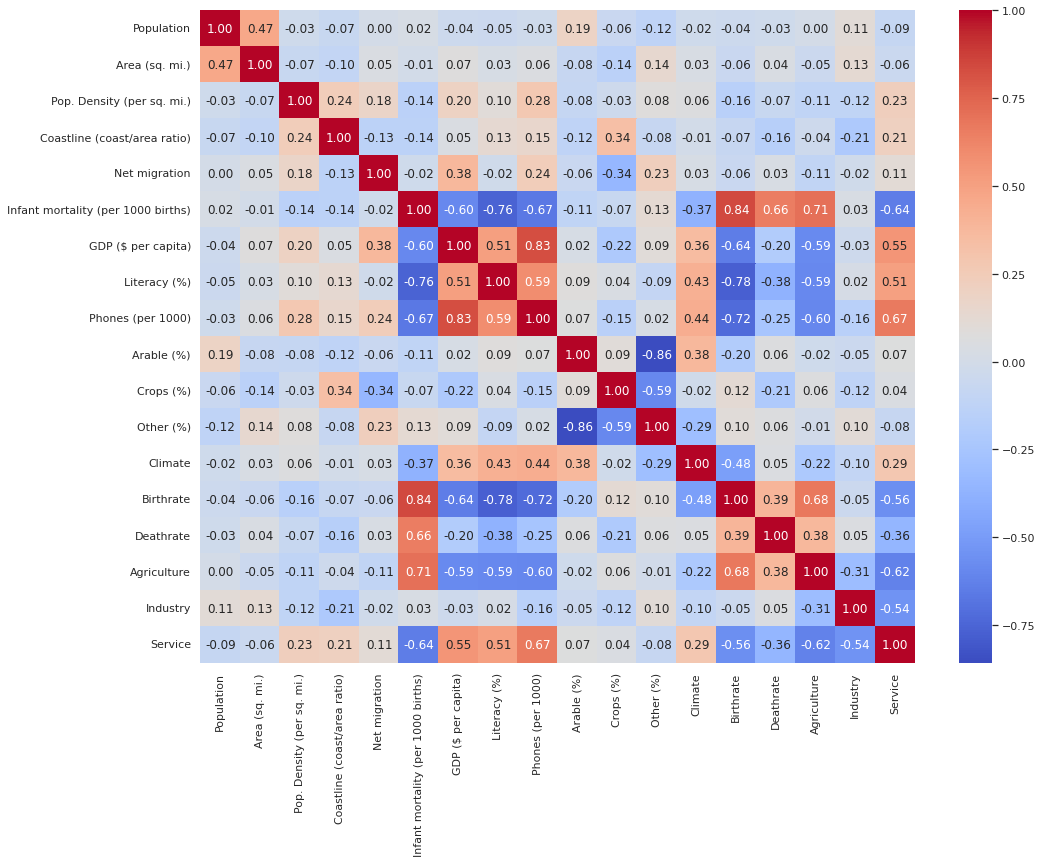

In [7]:
plt.figure(figsize=(16,12))
sns.heatmap(data=data.iloc[:,2:].corr(),annot=True,fmt='.2f',cmap='coolwarm')
plt.show()

###5.4 Top Factors Affecting GDP

We pick the six columns that mostly correlated to GDP per capita and make scatter plots. The results agree with our common sense. Also we notice there are many countries with low average GDP and few with high average GDP ---- a pyramid structure.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


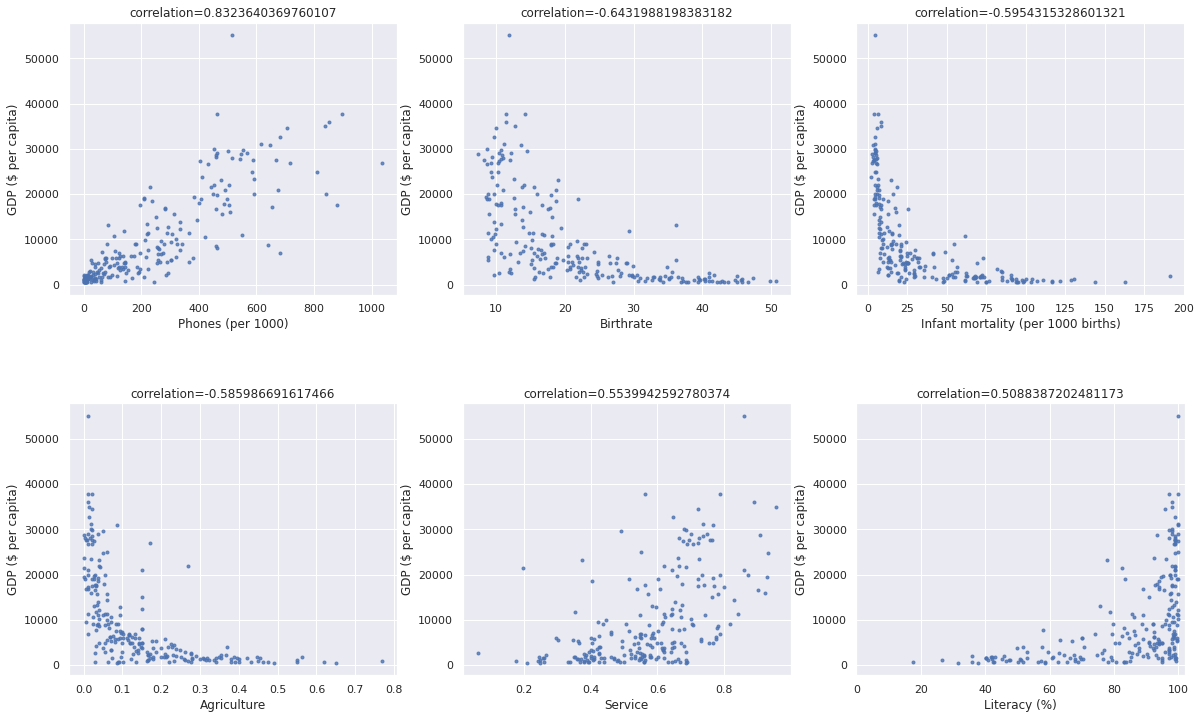

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,12))
plt.subplots_adjust(hspace=0.4)

corr_to_gdp = pd.Series()
for col in data.columns.values[2:]:
    if ((col!='GDP ($ per capita)')&(col!='Climate')):
        corr_to_gdp[col] = data['GDP ($ per capita)'].corr(data[col])
abs_corr_to_gdp = corr_to_gdp.abs().sort_values(ascending=False)
corr_to_gdp = corr_to_gdp.loc[abs_corr_to_gdp.index]

for i in range(2):
    for j in range(3):
        sns.regplot(x=corr_to_gdp.index.values[i*3+j], y='GDP ($ per capita)', data=data,
                   ax=axes[i,j], fit_reg=False, marker='.')
        title = 'correlation='+str(corr_to_gdp[i*3+j])
        axes[i,j].set_title(title)
axes[1,2].set_xlim(0,102)
plt.show()

 ### 5.5 Countries With Low Birthrate & Low GDP

Some features, like phones, are related to the average GDP more linearly, while others are not. For example, High birthrate usually means low GDP per capita, but average GDP in low birthrate countries can vary a lot. 

Let's look at the countries with low birthrate (<14%) and low GDP per capita (<10000 $). They also have hight literacy, like other high average GDP countires. But we hope their other features can help distiguish them from those with low birthrate but high average GDPs, like service are not quite an importent portion in their economy, not a lot phone procession, some have negative net migration... And many of them are from eastern Europe or C.W. of IND. STATES, so the 'region' feature may also be useful.

In [ ]:
data.loc[(data['Birthrate']<14)&(data['GDP ($ per capita)']<10000)]

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
9,Armenia,C.W. OF IND. STATES,2976372,29800,99.9,0.00,-6.47,23.28,3500.0,98.6,195.7,17.55,2.30,80.15,4.0,12.07,8.23,0.239,0.343,0.418
18,Belarus,C.W. OF IND. STATES,10293011,207600,49.6,0.00,2.54,13.37,6100.0,99.6,319.1,29.55,0.60,69.85,4.0,11.16,14.02,0.093,0.316,0.591
25,Bosnia & Herzegovina,EASTERN EUROPE,4498976,51129,88.0,0.04,0.31,21.05,6100.0,98.6,215.4,13.60,2.96,83.44,4.0,8.77,8.27,0.142,0.308,0.550
30,Bulgaria,EASTERN EUROPE,7385367,110910,66.6,0.32,-4.58,20.55,7600.0,98.6,336.3,40.02,1.92,58.06,3.0,9.65,14.27,0.093,0.304,0.603
42,China,ASIA (EX. NEAR EAST),1313973713,9596960,136.9,0.15,-0.40,24.18,5000.0,90.9,266.7,15.40,1.25,83.35,1.5,13.25,6.97,0.125,0.473,0.403
51,Cuba,LATIN AMER. & CARIB,11382820,110860,102.7,3.37,-1.58,6.33,2900.0,97.0,74.7,33.05,7.60,59.35,2.0,11.89,7.22,0.055,0.261,0.684
75,Georgia,C.W. OF IND. STATES,4661473,69700,66.9,0.44,-4.70,18.59,2500.0,99.0,146.6,11.44,3.86,84.70,3.0,10.41,9.23,0.172,0.275,0.553
123,Macedonia,EASTERN EUROPE,2050554,25333,80.9,0.00,-1.45,10.09,6700.0,98.6,260.0,22.26,1.81,75.93,3.0,12.02,8.77,0.118,0.319,0.563
168,Romania,EASTERN EUROPE,22303552,237500,93.9,0.09,-0.13,26.43,7000.0,98.4,196.9,40.82,2.25,56.93,3.0,10.70,11.77,0.101,0.350,0.549
169,Russia,C.W. OF IND. STATES,142893540,17075200,8.4,0.22,1.02,15.39,8900.0,99.6,280.6,7.33,0.11,92.56,4.0,9.95,14.65,0.054,0.371,0.575


##7. Total GDP

###7.1 Top Countries

It is also interesting to look at the total GDPs, which I take as 'GDP ($ per capita)' × 'Population'.

Here are the top 10 countries with highest total GDPs, their GDP make up to about 2/3 of the global GDP. 

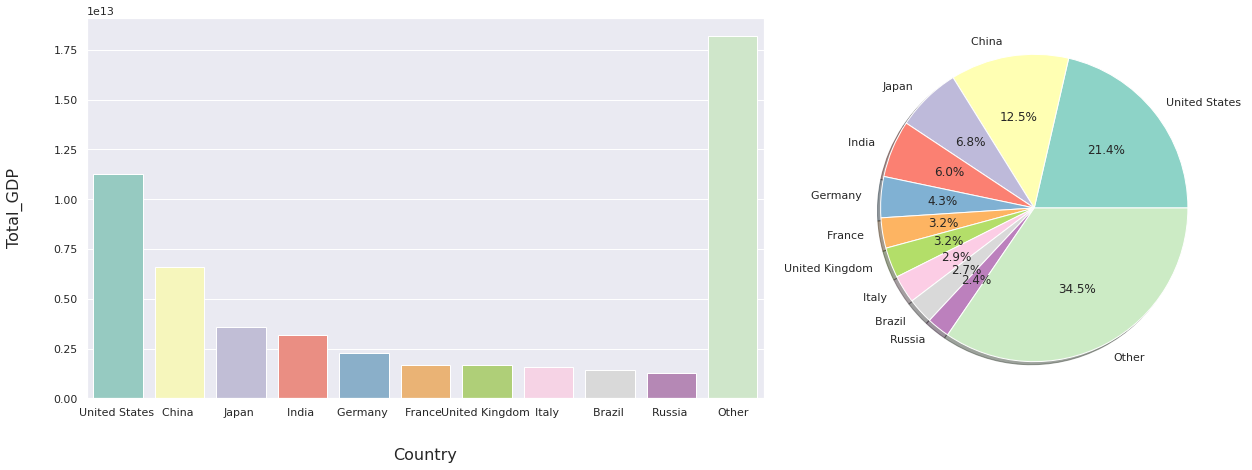

In [9]:
data['Total_GDP ($)'] = data['GDP ($ per capita)'] * data['Population']
#plt.figure(figsize=(16,6))
top_gdp_countries = data.sort_values('Total_GDP ($)',ascending=False).head(10)
other = pd.DataFrame({'Country':['Other'], 'Total_GDP ($)':[data['Total_GDP ($)'].sum() - top_gdp_countries['Total_GDP ($)'].sum()]})
gdps = pd.concat([top_gdp_countries[['Country','Total_GDP ($)']],other],ignore_index=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7),gridspec_kw = {'width_ratios':[2,1]})
sns.barplot(x='Country',y='Total_GDP ($)',data=gdps,ax=axes[0],palette='Set3')
axes[0].set_xlabel('Country',labelpad=30,fontsize=16)
axes[0].set_ylabel('Total_GDP',labelpad=30,fontsize=16)

colors = sns.color_palette("Set3", gdps.shape[0]).as_hex()
axes[1].pie(gdps['Total_GDP ($)'], labels=gdps['Country'],colors=colors,autopct='%1.1f%%',shadow=True)
axes[1].axis('equal')
plt.show()

Let's compare the above ten countries' rank in total GDP and GDP per capita.

In [10]:
Rank1 = data[['Country','Total_GDP ($)']].sort_values('Total_GDP ($)', ascending=False).reset_index()
Rank2 = data[['Country','GDP ($ per capita)']].sort_values('GDP ($ per capita)', ascending=False).reset_index()
Rank1 = pd.Series(Rank1.index.values+1, index=Rank1.Country)
Rank2 = pd.Series(Rank2.index.values+1, index=Rank2.Country)
Rank_change = (Rank2-Rank1).sort_values(ascending=False)
print('rank of total GDP - rank of GDP per capita:')
Rank_change.loc[top_gdp_countries.Country]

rank of total GDP - rank of GDP per capita:


Country
United States        1
China              118
Japan               14
India              146
Germany             15
France              15
United Kingdom      12
Italy               17
Brazil              84
Russia              75
dtype: int64

We see the countries with high total GDPs are quite different from those with high average GDPs.

China and India jump above a lot when it comes to the total GDP.

The only country that is with in top 10 (in fact top 2) for both total and average GDPs is the United States.

###7.2 Factors Affecting Total GDP

We can also check the correlation between total GDP and the other columns. The top two factors are population and area, following many factors that have also been found mostly correlated to GDP per capita.

In [11]:
corr_to_gdp = pd.Series()
for col in data.columns.values[2:]:
    if ((col!='Total_GDP ($)')&(col!='Climate')&(col!='GDP ($ per capita)')):
        corr_to_gdp[col] = data['Total_GDP ($)'].corr(data[col])
abs_corr_to_gdp = corr_to_gdp.abs().sort_values(ascending=False)
corr_to_gdp = corr_to_gdp.loc[abs_corr_to_gdp.index]
print(corr_to_gdp)

Population                            0.639528
Area (sq. mi.)                        0.556396
Phones (per 1000)                     0.233484
Birthrate                            -0.166889
Agriculture                          -0.139516
Arable (%)                            0.129928
Infant mortality (per 1000 births)   -0.122076
Literacy (%)                          0.099417
Service                               0.085096
Crops (%)                            -0.077078
Coastline (coast/area ratio)         -0.065211
Other (%)                            -0.064882
Net migration                         0.054632
Industry                              0.050399
Deathrate                            -0.035820
Pop. Density (per sq. mi.)           -0.028487
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


###7.3 Comparision Of The Top 10

> Indented block



Finally, let us do a comparison of the enconomy structure for the ten countries with hightest total GDP.

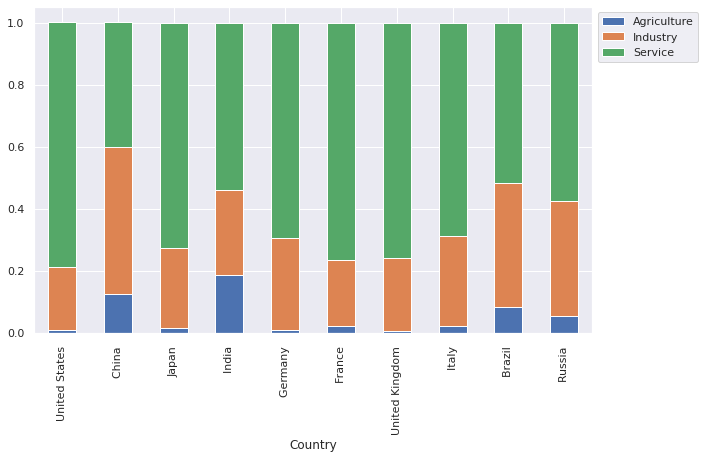

In [12]:
plot_data = top_gdp_countries.head(10)[['Country','Agriculture', 'Industry', 'Service']]
plot_data = plot_data.set_index('Country')
ax = plot_data.plot.bar(stacked=True,figsize=(10,6))
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

As well as their land usage:

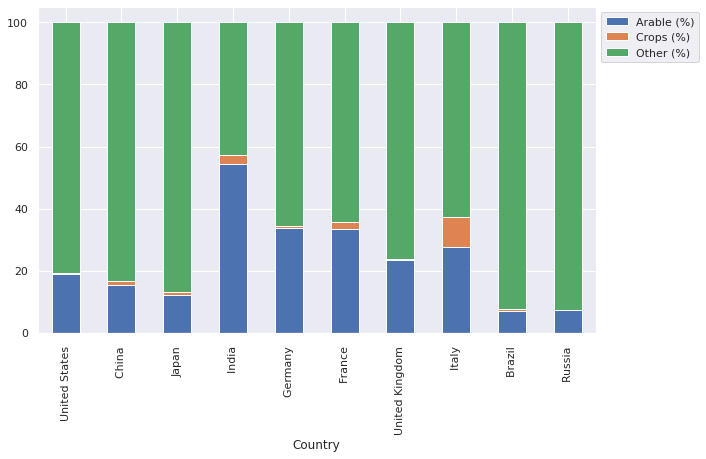

In [13]:
plot_data = top_gdp_countries[['Country','Arable (%)', 'Crops (%)', 'Other (%)']]
plot_data = plot_data.set_index('Country')
ax = plot_data.plot.bar(stacked=True,figsize=(10,6))
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

<a id='8'>8. References</a>
<ul>
  <li><a href='https://docs.scipy.org/doc/numpy/'>Numpy</a></li>
  <li><a href='https://pandas.pydata.org/'>Pandas</a></li>
  <li><a href='https://matplotlib.org/'>Matplotlib</a></li>
  <li><a href='https://seaborn.pydata.org/'>Seaborn</a></li>
  <li><a href='https://scikit-learn.org'>Scikit-Learn</a></li>
</ul>